In [1]:
%load_ext autoreload
%autoreload 2
from chronos import Chronos

utm = 32631
chr = Chronos(delta_min=20, cc1=0, cc2=75, buffer=0, nodata=10, crs='EPSG:32631', 
            alpha = 0.1, show_aoi=False, shadow=True, registration=True,
            satellites=['sentinel-2'],
            pansharpening=True, sharpening=True, force_reproject=False, 
            normalization=None, verbose=2, n_jobs=8, prefer='threads')

/Users/arthurcalvi/Venv/Download/lib/python3.9/site-packages/rasterio/path.py:15: RasterioDeprecationWarning: rasterio.path will be removed in version 1.4.
  warnings.warn(


In [2]:
import geopandas as gpd
import pandas as pd
from datetime import datetime
import os 



directory = '/Users/arthurcalvi/Data/results/disturbances/matching_france_v04_EPSG3857.parquet'
#Load disturbances, convert to utm coordinates 
gdf = gpd.read_parquet(directory).to_crs(epsg=utm)

#filtering duplicates
gdf.drop_duplicates(subset=['index_SS', 'year'], inplace=True)
gdf.shape[0]


5870700

In [3]:
gdf = gdf[ (gdf.year >= 2018)&(gdf.year <= 2020) ] 
classes = ['Fire', 'Biotic-dieback', 'Biotic-mortality']
gdf = gdf[ gdf['class'].isin(classes) ]

In [4]:
dir_ = '/Users/arthurcalvi/Data/disturbances-ex/france_var'
name_dict = 'dict_aoi_var.pkl '

#load pkl from path
import pickle
import os

path = os.path.join(dir_, name_dict)
with open(path, 'rb') as f:
    dict_aoi = pickle.load(f)

  0%|          | 0/3 [00:00<?, ?it/s]

Nbr of already downloaded aoi: 1
downloading at: /Users/arthurcalvi/Data/disturbances-ex/france_var/20150102_20231231_Var, France_fr-ProvenceAlpesCote-dAzur-Var_Lat43.75_Lon6.49_Biotic-dieback
satellites used: ['sentinel-2']


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    2.5s finished


Items found for research 1 with cc=0 : 0


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    5.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   17.2s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:   37.9s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   53.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   0 out of   0 | elapsed:    0.0s finished


Items accepted during research 2 with cc=25 (on aoi) : 0
Items found for combined research:  0
Critical Issue with the tile


  0%|          | 0/9 [00:00<?, ?it/s]

downloading at: /Users/arthurcalvi/Data/disturbances-ex/france_var/20150102_20231231_Var, France_fr-ProvenceAlpesCote-dAzur-Var_Lat43.59_Lon6.51_Fire
satellites used: ['sentinel-2']


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.2s finished


Items found for research 1 with cc=0 : 0


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   11.8s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:   24.4s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   35.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   0 out of   0 | elapsed:    0.0s finished


Items accepted during research 2 with cc=25 (on aoi) : 0
Items found for combined research:  0
Critical Issue with the tile
downloading at: /Users/arthurcalvi/Data/disturbances-ex/france_var/20150102_20231231_Var, France_fr-ProvenceAlpesCote-dAzur-Var_Lat43.45_Lon6.70_Fire
satellites used: ['sentinel-2']


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    1.2s finished


Items found for research 1 with cc=0 : 1


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    4.2s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   13.7s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:   30.9s
[Parallel(n_jobs=8)]: Done 499 out of 499 | elapsed:   44.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


Items accepted during research 2 with cc=25 (on aoi) : 0
Items found for combined research:  1
upper bound :  nan


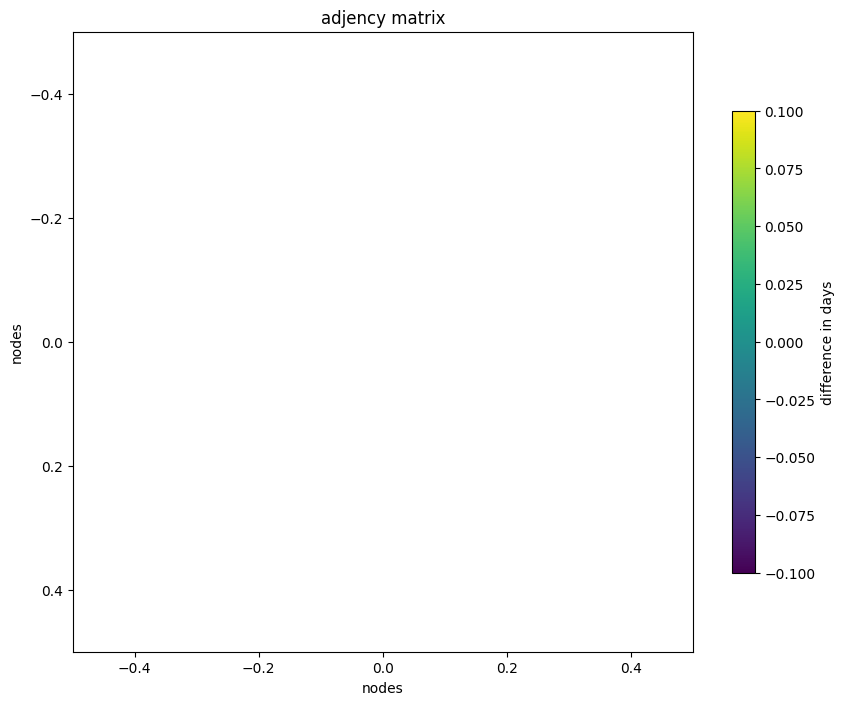

is strongly connected :  True
is weakly connected :  True


KeyError: -9

In [5]:
from datetime import timedelta, timezone
from utils2 import localisation
from rasterio.warp import transform_geom

#import tqdm for notebooks
from tqdm.notebook import tqdm

count_download = 0
delta = timedelta(days=3*365)
first = True

for region in dict_aoi.keys():

    for cause in dict_aoi[region].keys():

        for current_aoi in tqdm(dict_aoi[region][cause]):

            
            gdf_neighbors = gdf.clip(current_aoi)
            

            #downlaod data
            download = True
            start_date = datetime(gdf_neighbors.year.min(), 1, 1, 10, 10, 10, tzinfo=timezone.utc) - delta
            end_date = datetime(gdf_neighbors.year.max(), 12, 31, 10, 10, 10, tzinfo=timezone.utc) + delta

            #loc
            #transform current aoi to epsg:4326 with rasterio.warp.transform_geom
            current_aoi_4326 = transform_geom('EPSG:{}'.format(utm), 'EPSG:4326', current_aoi.__geo_interface__)
            name, Latitude, Longitude = localisation(current_aoi_4326)
            current_aoi = gpd.GeoDataFrame({'geometry': [current_aoi]}, crs='epsg:{}'.format(utm)).geometry.iloc[0]

            

            name_folder = '_'.join([start_date.strftime('%Y%m%d'), end_date.strftime('%Y%m%d'), region, name, f'Lat{float(Latitude) :.2f}', f'Lon{float(Longitude) :.2f}', str(cause)])
            folder = os.path.join(dir_, name_folder)

            #read if there is a log.txt
            if os.path.isfile(os.path.join(folder, 'download.txt')):
                with open(os.path.join(folder, 'download.txt'), 'r') as f:
                    log = f.read()

                #if there is a log.txt and it is OK, pass
                if log == 'Download: OK':
                    download = False
                    count_download += 1

            if download :
                if first:
                    print('Nbr of already downloaded aoi:', count_download)

                # try :
                print('downloading at:', folder)
                results = chr.download(folder, current_aoi, start_date, end_date, \
                        indices=['rgb', 'ndvi', 'evi', 'crswir', 'nbr', 'qa', 'cloud_mask']) 
                log = 'Download: OK'
                #write log inside folder
                with open(os.path.join(folder, 'download.txt'), 'w') as f:
                    f.write(log)


                #write gdf_neighbors in parquet file
                gdf_neighbors.to_parquet(os.path.join(folder, 'disturbance.parquet'))


                # except : 
                #     shutil.rmtree(folder)
                first = False

In [28]:
dict_cause = {
    'biotic-mortality': 1,
    'biotic-dieback': 2, 
    'fire': 3,
    'storm': 4,
    'drought': 5,
    'tree-logging': 6,
}

import rasterio 
from rasterio.features import rasterize

for folder in tqdm(os.listdir(dir_)):

    if os.path.isdir(os.path.join(dir_, folder)):

        path = os.path.join(dir_, folder)

        #read disturbance.parquet
        gdf = gpd.read_parquet(os.path.join(path, 'disturbance.parquet'))

        #read one the first raster inside the rgb folder
        rgb = os.listdir(os.path.join(path, 'rgb'))[0]
        rgb = os.path.join(path, 'rgb', rgb)
        #load raster
        rgb = rasterio.open(rgb)

        #change crs of gdf to rgb.crs
        gdf = gdf.to_crs(rgb.crs)

        #Rasterize geometry inside gdf and burn it inside a raster.
        #The raster is the same as rgb but the value depend on the cause of disturbance gdf['cause']

        #create a raster with the same shape as rgb
        gdf['class'] = gdf['class'].apply(lambda x: dict_cause[x.lower()])

        #rasterize gdf
        shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf['class']))
        rasterized = rasterize(shapes, out_shape=(rgb.height, rgb.width), transform=rgb.transform, fill=0, all_touched=True, dtype='uint8')

        #write rasterized inside a raster named disturbance.tif
        ##change rgb.meta['count'] to 1
        rgb.meta['count'] = 1
        rgb.meta['dtype'] = 'uint8'
        with rasterio.open(os.path.join(path, 'disturbance.tif'), 'w', **rgb.meta) as dst:
            dst.write(rasterized, 1)


    



  0%|          | 0/8 [00:00<?, ?it/s]